<a href="https://colab.research.google.com/github/elenasofia98/PracticalNLP-2023-2024/blob/main/HoL03_1_ParaphraseClassification_FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install stanza

# Recognizing Paraphrases

In [4]:
import stanza
nlp = stanza.Pipeline('en', processors='tokenize,lemma,pos,depparse')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


## MRPC (Microsoft Research Paraphrase Corpus)
Introduced by William B. Dolan et al. in Automatically Constructing a Corpus of Sentential Paraphrases
Microsoft Research Paraphrase Corpus (MRPC) is a corpus consists of 5,801 sentence pairs collected from newswire articles. Each pair is labelled if it is a paraphrase or not by human annotators. The whole set is divided into a training subset (4,076 sentence pairs of which 2,753 are paraphrases) and a test subset (1,725 pairs of which 1,147 are paraphrases).

In [6]:
!pip install datasets
from datasets import load_dataset
# https://huggingface.co/docs/datasets/index


from ast import literal_eval

def parse(example, nlp):
    parsed_example = {}
    for i in [1,2]:
        parsed_sent = nlp(example[f'sentence{i}'])
        for feature in [k+str(i) for k in ['words', 'deprel', 'heads', 'headsidx']]:
            parsed_example[feature] = []

        for sent in parsed_sent.sentences:
            for word in sent.words:
                parsed_example[f'words{i}'].append(word.text)

                parsed_example[f'deprel{i}'].append(word.deprel)

                head_idx = word.head-1
                parsed_example[f"headsidx{i}"].append(head_idx)

                head = sent.words[head_idx].text if head_idx > 0 else "root"
                parsed_example[f"heads{i}"].append(head)

    return parsed_example


def literal_parse(example):
    literal_ex ={}
    for column in example.keys():
        if column in ['sentence1', 'sentence2', 'label', 'idx']:
            literal_ex[column] = example[column]
        elif column == 'Unnamed: 0':
            continue
        else:
            literal_ex[column] = literal_eval(example[column])
    return literal_ex

import os
if not os.path.exists('train_pd.csv') or not os.path.exists('valid_pd.csv'):
    dataset = load_dataset("glue", "mrpc",  split={"train":'train[:20%]','validation':'validation[:20%]'})
    for split in ['train', 'validation']:
        dataset[split] = dataset[split].map(lambda x: parse(x, nlp=nlp), batched=False, num_proc=128)
else:
    dataset = load_dataset("csv",  data_files={"train":'train_pd.csv','validation':'train_pd.csv'})
    for split in ['train', 'validation']:
        dataset[split] = dataset[split].map(lambda x: literal_parse(x))
display(dataset)
display(dataset['train'][0])

Map:   0%|          | 0/734 [00:00<?, ? examples/s]

Map:   0%|          | 0/734 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'sentence1', 'sentence2', 'label', 'idx', 'words1', 'pos1', 'deprel1', 'heads1', 'headsidx1', 'words2', 'pos2', 'deprel2', 'heads2', 'headsidx2'],
        num_rows: 734
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'sentence1', 'sentence2', 'label', 'idx', 'words1', 'pos1', 'deprel1', 'heads1', 'headsidx1', 'words2', 'pos2', 'deprel2', 'heads2', 'headsidx2'],
        num_rows: 734
    })
})

{'Unnamed: 0': 0,
 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0,
 'words1': ['Amrozi',
  'accused',
  'his',
  'brother',
  ',',
  'whom',
  'he',
  'called',
  '"',
  'the',
  'witness',
  '"',
  ',',
  'of',
  'deliberately',
  'distorting',
  'his',
  'evidence',
  '.'],
 'pos1': ['PROPN',
  'VERB',
  'PRON',
  'NOUN',
  'PUNCT',
  'PRON',
  'PRON',
  'VERB',
  'PUNCT',
  'DET',
  'NOUN',
  'PUNCT',
  'PUNCT',
  'SCONJ',
  'ADV',
  'VERB',
  'PRON',
  'NOUN',
  'PUNCT'],
 'deprel1': ['nsubj',
  'root',
  'nmod:poss',
  'obj',
  'punct',
  'obj',
  'nsubj',
  'acl:relcl',
  'punct',
  'det',
  'xcomp',
  'punct',
  'punct',
  'mark',
  'advmod',
  'advcl',
  'nmod:poss',
  'obj',
  'punct'],
 'heads1': ['accused',
  'root',
  'brother',
  'accused',
  'brother'

https://aclanthology.org/U06-1019.pdf
### Using Dependency-Based Features to Take the “Para-farce” out of Paraphrase

"We propose that an automatic classifier be employed to identify and filter out inconsistent novel
sentences. To do so, we couch Paraphrase Classification as a supervised machine learning task and
train a classifier on the Microsoft Research Paraphrase (MSR) Corpus (Dolan et al., 2004), a corpus specifically collected for this task. In particular, we are especially interested in exploring the
use of syntactic dependency information in making this classification.
[...]
In this paper, we decided to explore features encoding information about the relative difference
between the structures of the two sentence.
We
thus experimented with a range of features ranging
from differences in sentence length, to word overlap, to syntax dependency tree overlap, where the
latter approximately represent predicate and argument structure.

1. **unigram recall**
2. **unigram precision**
3. lemmatised unigram precision
4. lemmatised unigram recall
5. Bleu precision
6. Bleu recall
7. lemmatised Bleu precision
8. lemmatised Bleu recall
9. fmeasure
10. **dependency relation precision**
11. **dependency relation recall**
12. lemmatised dependency relation precision
13. lemmatised dependency relation recall
14. **tree-edit distance (Zhang and Sasha algorithm)**
15. lemmatised tree-edit distance (Zhang and Sasha algorithm)
16. difference in sentence length (in words)
17. absolute difference in sentence length (in words)
"

In [63]:
import pandas as pd

TRAIN = 'train'
TEST = 'validation'

splits = [TRAIN, TEST]
X = {split: pd.DataFrame([]) for split in splits}

In [64]:
def overlap(s1, s2):
    s1 = set(s1)
    s2 = set(s2)

    return len(s1.intersection(s2))

#### Lexical features

In [65]:
# precision = word-overlap(sentence1,sentence2)/word-count(sentence1)
# recall = word-overlap(sentence1,sentence2)/word-count(sentence2)

for split in splits:
    X[split]['precision']   = [overlap(example['words1'], example['words2'])/len(set(example['words1'])) for example in dataset[split]]
    X[split]['recall']      = [overlap(example['words2'], example['words1'])/len(set(example['words2'])) for example in dataset[split]]

In [66]:
# A relation is simply a pair of words in a parent-child relationship within the dependency tree, refered to as head-modifier relationships.
# In this paper, we ignored the label of the relationships which indicates the semantic role.
# The next series of features examines the use of features based on an overlap of such head-modifier relations (hereafter, relations) between sentences.

#### Dependency overlap

In [67]:
# Feature 10 is the precision score calculated from the overlap according to the following formula:
# precisiond (dependency precision) = |relations(sentence1) ∩ relations(sentence2)|/|relations(sentence1)|
# where relations(sentence_i) is the set of headmodifier relations for some sentence.

def relations(example, sentence_index):
    rels = []
    for i in range(len(example[f"words{sentence_index}"])):
        rels.append((example[f"words{sentence_index}"][i],example[f"heads{sentence_index}"][i]))
    return rels

In [68]:
for split in splits:
    precisiond = []
    recalld = []
    for example in dataset[split]:
        relations1 = relations(example, 1)
        relations2 = relations(example, 2)

        precisiond.append(overlap(relations1, relations2)/len(set(relations1)))
        recalld.append(overlap(relations2, relations1)/len(set(relations2)))
    X[split]['precisiond'] = precisiond
    X[split]['recalld'] = recalld

#### Tree edit distance

In [69]:
# Including tree edit
# As another measure of how alike or different the two sentences are from each other,
# we decided to examine how similar their respective dependency trees were.
# Ordered tree-edit distance algorithms
# are designed to find the least costly set of operations that will transform one tree into another.
# In our case, we want to find the cost of transforming
# dependency parse trees

In [70]:
# Our implementation is based on the dynamic
# programming algorithm of Zhang and Shasha (1989).
# The algorithm finds the optimum (cheapest) set of tree-edit operations in polynomial time.
# This algorithm has been used in the past in
# Question-Answering as a means of scoring similarity between questions an candidate answers
! pip install zss

In [71]:
from zss import simple_distance, Node

In [72]:
def get_dtree(example, sentence_index):
    dtree = {}
    for i in range(len(example[f'words{sentence_index}'])):

        head = example[f'heads{sentence_index}'][i]
        head_idx = example[f'headsidx{sentence_index}'][i]
        if f"{head}_{head_idx}" not in dtree:
            dtree[f"{head}_{head_idx}"] = []

        dtree[f"{head}_{head_idx}"].append(f"{example[f'words{sentence_index}'][i]}_{i}")
    return dtree

def construct_tree(root, dtree):
    tree = Node(root)

    # is leaf
    if root not in dtree:
        return tree

    # has children
    children = dtree[root]
    for child in children:
        subtree = construct_tree(root=child, dtree=dtree) # recursevely, build the subtree rooted in each children
        tree = tree.addkid(subtree)

    return tree

In [73]:
# We calculated the tree-edit distance over the syntactic dependency parse trees.
# Inserting, deleting and renaming nodes, or words,
# into a dependency tree, were all given an equal cost.
# The cost returned by the algorithm is simply the
# sum of all operations required to transform one
# tree into the other. This cost was normalised by
# the number nodes in the target dependency tree to
# produce a value between 0 and 1

In [74]:
from tqdm import tqdm

In [75]:
root='root_-1'
for split in splits:
    ted = []
    for example in tqdm(dataset[split]):
        tree1 = construct_tree(root=root, dtree=get_dtree(example, sentence_index=1))
        tree2 = construct_tree(root=root, dtree=get_dtree(example, sentence_index=2))

        ted.append(simple_distance(tree1, tree2)/len(example['words2']))

    X[split]['ted'] = ted

100%|██████████| 734/734 [00:25<00:00, 28.79it/s]


#### Classifier

In [76]:
for split in splits:
    X[split]['target'] = [example['label'] for example in dataset[split]]

In [77]:
X[TRAIN]

,precision,recall,precisiond,recalld,ted,target
0,0.812500,0.722222,0.666667,0.631579,3.400000,1
1,0.647059,0.578947,0.294118,0.238095,4.318182,0
2,0.777778,0.736842,0.523810,0.523810,4.818182,1
3,0.576923,0.750000,0.357143,0.476190,6.190476,0
4,0.545455,0.571429,0.208333,0.227273,4.695652,1
...,...,...,...,...,...,...
729,0.571429,0.444444,0.333333,0.263158,6.842105,0
730,0.518519,0.482759,0.200000,0.200000,6.200000,0
731,0.739130,0.850000,0.583333,0.666667,4.476190,0
732,0.571429,0.640000,0.375000,0.428571,3.700000,1


In [78]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='poly', degree=3)


X_train = X[TRAIN][[feature for feature in X[TRAIN].columns if feature!='target']]
y_train = X[TRAIN]['target']


SVM.fit(X_train, y_train)

SVC(kernel='poly')

In [79]:
pred_train = SVM.predict(X_train)

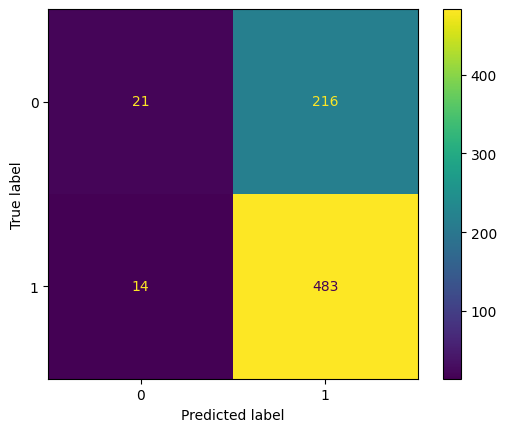

In [80]:
cm = confusion_matrix(y_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

In [81]:
print(classification_report(y_pred=pred_train, y_true=y_train))

              precision    recall  f1-score   support

           0       0.60      0.09      0.15       237
           1       0.69      0.97      0.81       497

    accuracy                           0.69       734
   macro avg       0.65      0.53      0.48       734
weighted avg       0.66      0.69      0.60       734



In [82]:
X_test = X[TEST][[feature for feature in X[TEST].columns if feature!='target']]
y_test = X[TEST]['target']

pred_test = SVM.predict(X_test)

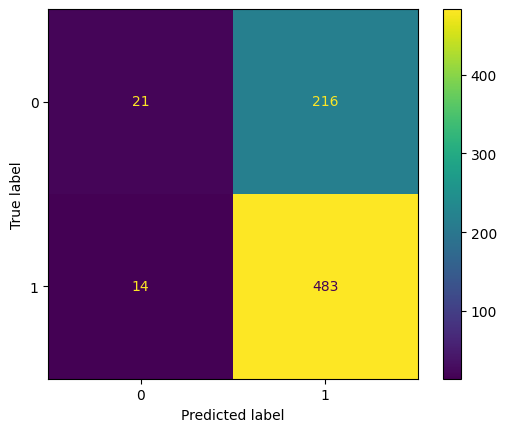

In [83]:
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

In [84]:
print(classification_report(y_pred=pred_test, y_true=y_test))

              precision    recall  f1-score   support

           0       0.60      0.09      0.15       237
           1       0.69      0.97      0.81       497

    accuracy                           0.69       734
   macro avg       0.65      0.53      0.48       734
weighted avg       0.66      0.69      0.60       734



#### Feature Selection
https://scikit-learn.org/stable/modules/feature_selection.html

Feature selection is focused on removing non-informative or redundant predictors from the model.

##### Univariate feature selection

Numerical Input, Categorical Output
This is a classification predictive modeling problem with numerical input variables.

This might be the most common example of a classification problem,

Again, the most common techniques are correlation based, although in this case, they must take the categorical target into account.

ANOVA correlation coefficient (linear).
Kendall’s rank coefficient (nonlinear).

In [85]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=4)
selector = selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['precision', 'recall', 'precisiond', 'recalld'], dtype=object)

Feature precision: 114.111238
Feature recall: 107.330034
Feature precisiond: 65.380040
Feature recalld: 63.550708
Feature ted: 46.323758


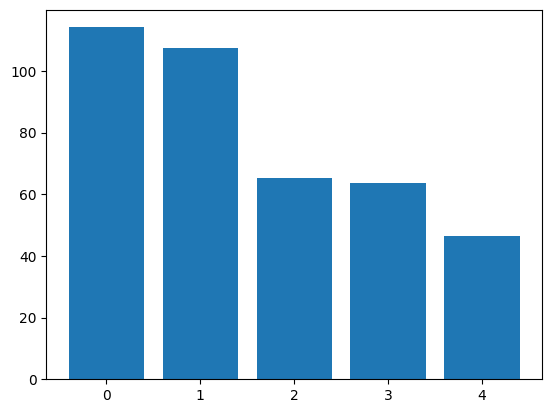

In [86]:
from matplotlib import pyplot as plt

for i in range(len(selector.scores_)):
 print('Feature %s: %f' % (selector.feature_names_in_[i], selector.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(selector.scores_))], selector.scores_)
plt.show()


In [87]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='poly', degree=3)


X_train = X[TRAIN][[feature for feature in X[TRAIN].columns if feature in selector.get_feature_names_out()]]
y_train = X[TRAIN]['target']


SVM.fit(X_train, y_train)

SVC(kernel='poly')

              precision    recall  f1-score   support

           0       0.60      0.53      0.56       237
           1       0.79      0.83      0.81       497

    accuracy                           0.73       734
   macro avg       0.69      0.68      0.69       734
weighted avg       0.73      0.73      0.73       734



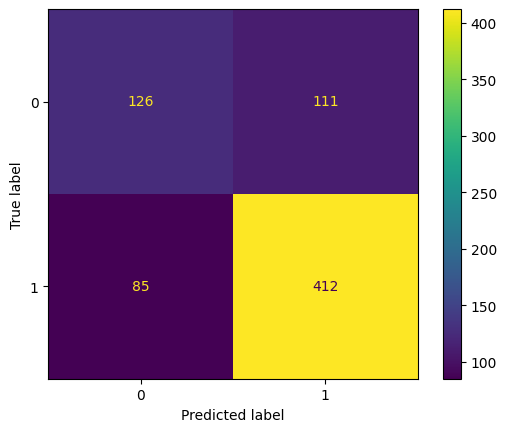

In [88]:
pred_train = SVM.predict(X_train)
cm = confusion_matrix(y_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()
print(classification_report(y_pred=pred_train, y_true=y_train))

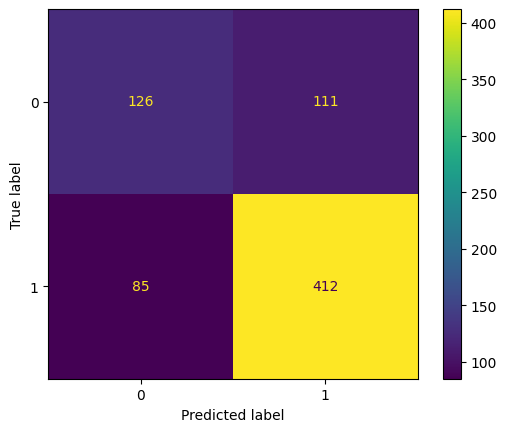

In [89]:
X_test = X[TEST][[feature for feature in X[TEST].columns if feature in selector.get_feature_names_out()]]
y_test = X[TEST]['target']

pred_test = SVM.predict(X_test)

cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

In [90]:
print(classification_report(y_pred=pred_test, y_true=y_test))

              precision    recall  f1-score   support

           0       0.60      0.53      0.56       237
           1       0.79      0.83      0.81       497

    accuracy                           0.73       734
   macro avg       0.69      0.68      0.69       734
weighted avg       0.73      0.73      0.73       734

